In [23]:
# PREAMBLE
%matplotlib inline

import re
import io
import os.path
from functools import reduce

import pandas as pd

import numpy as np

from ggplot import *

In [25]:
# PROCESS SAR CPU METRICS
FIND_CPU = re.compile(".+ all .+")
CPU_COLS = ["cpu"]
SAMPLES = 5
SAMPLE_RANGE = range(1, SAMPLES+1)

cpu_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_CPU.match, open(fname)))), header=None)\
                             .loc[:,[8]]

async_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
async_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
async_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "async_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in async_no_ssl_cpus + async_yes_sse_cpus + async_yes_ssl_cpus:
    df.columns = CPU_COLS

async_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_no_ssl_cpus, 1)})
async_no_ssl_cpu.df_name = "no_ssl_cpu"
async_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_ssl_cpus, 1)})
async_yes_ssl_cpu.df_name = "yes_ssl_cpu"
async_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_sse_cpus, 1)})
async_yes_sse_cpu.df_name = "yes_sse_cpu"

async_cpu = [async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu]
for i in range(len(async_cpu)):
    df_name = async_cpu[i].df_name
    async_cpu[i]["t"] = async_cpu[i].index
    async_cpu[i] = pd.melt(async_cpu[i], ["t"], var_name="run", value_name=async_cpu[i].df_name)
    async_cpu[i].df_name = df_name

In [52]:
async_cpu[0].head()

,t,run,no_ssl_cpu
0,0,s1,0.06
1,1,s1,38.64
2,2,s1,86.74
3,3,s1,89.12
4,4,s1,55.07


In [26]:
async_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), async_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

## CPU

### 8 Concurrent Uploads

Legend:

+ **no_ssl_cpu** - Transfer to S3 with TLS/SSL *disabled* and Server Side Encryption *disabled*
+ **yes_ssl_cpu** - Transfer to S3 with TLS/SSL *enabled* and Server Side Encryption *disabled*
+ **yes_sse_cpu** - Transfer to S3 with TLS/SSL *enabled* and Server Side Encryption *enabled*


After 5 runs, the average CPU utilization is:

{{ async_cpu_df[["run_type","cpu"]].groupby(["run_type"]).mean() }}


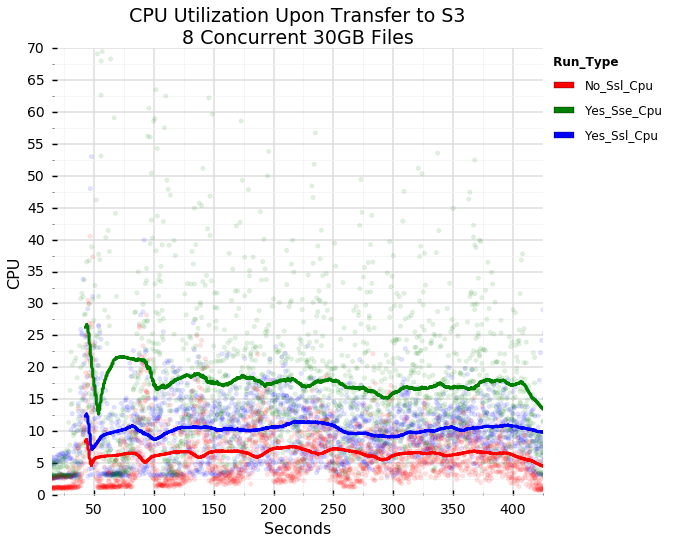

<ggplot: (-9223363242120135108)>

In [48]:
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=async_cpu_df) +\
    stat_smooth(size=3,  alpha=.9, se=False, method="ma") +\
    geom_jitter(alpha=.12) +\
    xlim(15,425) +\
    ylim(0,70) +\
    xlab("Seconds") +\
    ylab("CPU") +\
    ggtitle("CPU Utilization Upon Transfer to S3\n8 Concurrent 30GB Files") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/network-cpu-1.png",s,dpi=96)
s

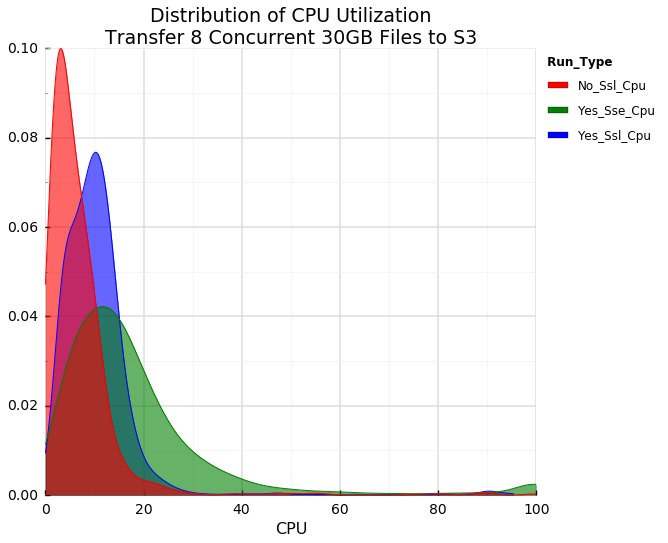

<ggplot: (-9223363242119914317)>

In [47]:
s = ggplot(aes(x='cpu', color='run_type', fill='run_type'), data=async_cpu_df) +\
    geom_density(alpha=.6) +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    xlab("CPU") +\
    ggtitle("Distribution of CPU Utilization\nTransfer 8 Concurrent 30GB Files to S3") +\
    theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/network-cpu-2.png",s,dpi=96)
s

In [29]:
# PROCESS SAR CPU METRICS
SAMPLES = 8
SAMPLE_RANGE = range(SAMPLES)

single_no_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
single_yes_ssl_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
single_yes_sse_cpus = tuple(cpu_df(os.path.join("reports2", "single_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in single_no_ssl_cpus + single_yes_sse_cpus + single_yes_ssl_cpus:
    df.columns = CPU_COLS

single_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_no_ssl_cpus)})
single_no_ssl_cpu.df_name = "no_ssl_cpu"
single_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_ssl_cpus)})
single_yes_ssl_cpu.df_name = "yes_ssl_cpu"
single_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_sse_cpus)})
single_yes_sse_cpu.df_name = "yes_sse_cpu"

single_cpu = [single_no_ssl_cpu, single_yes_ssl_cpu, single_yes_sse_cpu]

for i in range(len(single_cpu)):
    df_name = single_cpu[i].df_name
    single_cpu[i]["t"] = single_cpu[i].index
    single_cpu[i] = pd.melt(single_cpu[i], ["t"], var_name="run", value_name=single_cpu[i].df_name)
    single_cpu[i].df_name = df_name

In [51]:
single_cpu[0].head()

,t,run,no_ssl_cpu
0,0,s0,0.03
1,1,s0,26.55
2,2,s0,0.46
3,3,s0,0.53
4,4,s0,0.52


In [30]:
single_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), single_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

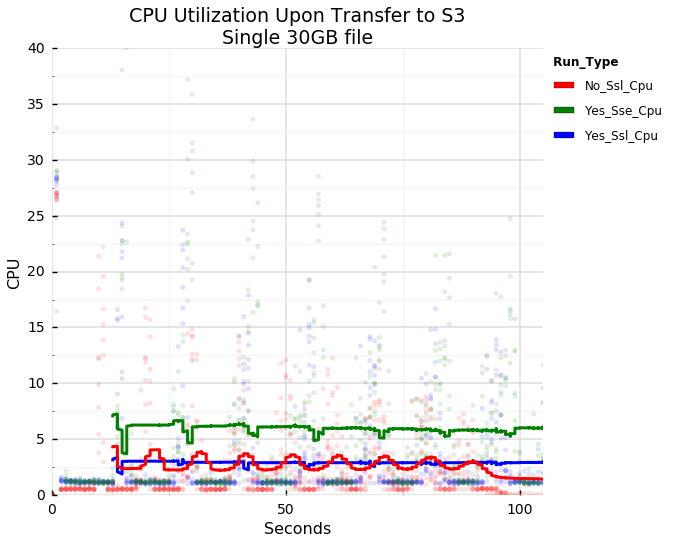

<ggplot: (8794734923107)>

In [45]:
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=single_cpu_df) +\
    stat_smooth(size=3,  alpha=.9, se=False, method="ma", window=105) +\
    geom_jitter(alpha=.12) +\
    xlim(0,105) +\
    ylim(0,40) +\
    xlab("Seconds") +\
    ylab("CPU") +\
    ggtitle("CPU Utilization Upon Transfer to S3\nSingle 30GB file") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk', style="whitegrid")
#ggsave("/tmp/single-network-cpu-1.png", s, dpi=96)
s

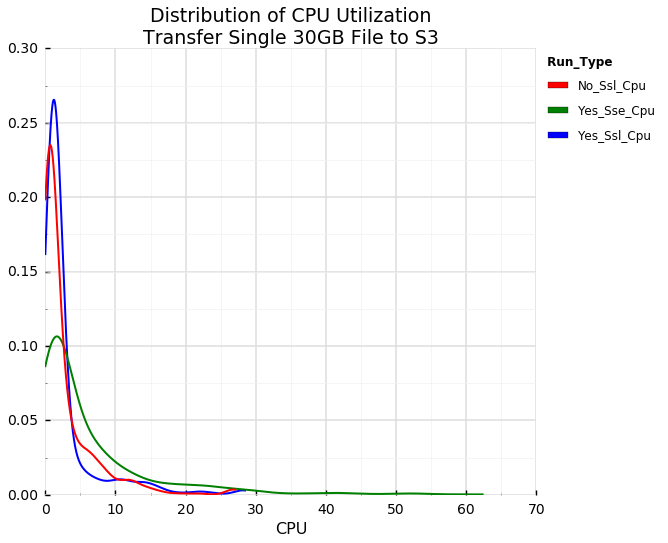

<ggplot: (-9223363242120206627)>

In [49]:
s = ggplot(aes(x='cpu', color='run_type'), data=single_cpu_df) +\
    geom_density(alpha=.6, size=2) +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    xlab("CPU") +\
    ggtitle("Distribution of CPU Utilization\nTransfer Single 30GB File to S3") +\
    theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/single-network-cpu-3.png",s,dpi=96)
s

### Disk I/O

In [35]:
samples = []
for dev in ("eph-p", "eph-e", "io-e", "io-p"): 
    with open(os.path.join("reports", "bonnie.{}.txt".format(dev)), "r") as f:
        samples.extend(dev.split("-") + l.strip().split(",") for l in f.readlines()[1:])

In [36]:
bonnie = pd.DataFrame(samples)[[0,1,11, 12, 13,17, 18, 39, 40,]+list(range(42,50))]
bonnie.columns=["dev_type", "enc_flag", "put_block", "put_block_cpu", "rewrite", "get_block",
"get_block_cpu", "put_block_latency","rewrite_latency",
"get_block_latency","seeks_latency","seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency","ran_stat_latency","ran_del_latency"]

for l in ("put_block", "get_block", "put_block_cpu", "get_block_cpu"):
    bonnie[l] = bonnie[l].apply(int)
    
for l in ("put_block_latency", "get_block_latency"):
    bonnie[l] = bonnie[l].apply(lambda x: int(x[:-2]) if x[-2:] == "us" else int(x[:-2])*1000)

In [37]:
bonnie.head()

,dev_type,enc_flag,put_block,put_block_cpu,rewrite,get_block,get_block_cpu,put_block_latency,rewrite_latency,get_block_latency,seeks_latency,seq_create_latency,seq_stat_latency,seq_del_latency,ran_create_latency,ran_stat_latency,ran_del_latency
0,eph,p,439625,28,180121,439533,14,22803,458ms,20886,4909us,136ms,274us,347ms,152ms,41us,282ms
1,eph,p,440489,29,181749,439541,14,26011,378ms,15698,389us,138ms,272us,253ms,138ms,49us,287ms
2,eph,p,433757,28,178483,439745,14,26556,403ms,9400,575us,154ms,447us,215ms,137ms,47us,244ms
3,eph,p,406842,27,178898,439132,14,38160,404ms,21083,2004us,141ms,272us,231ms,162ms,49us,301ms
4,eph,p,407786,27,180905,428006,13,28688,432ms,21548,1731us,155ms,272us,300ms,150ms,48us,289ms


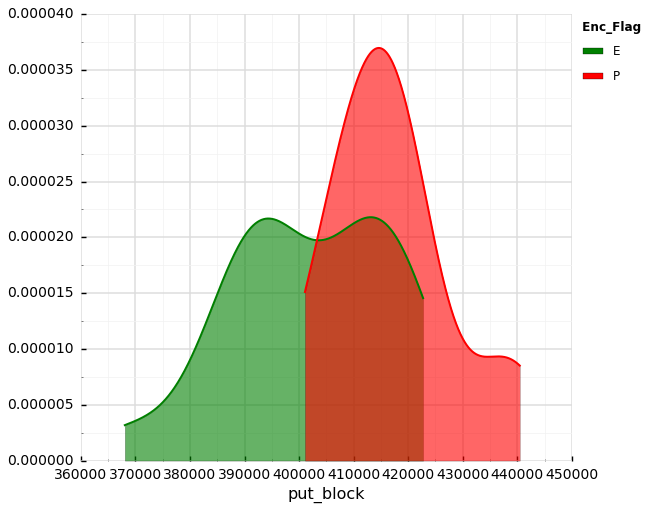

<ggplot: (8794735608910)>

In [38]:
s = ggplot(aes(x="put_block", color="enc_flag",fill="enc_flag"), data=bonnie[bonnie.dev_type == "eph"]) +\
    geom_density(alpha=.6, size=2) +\
    scale_color_manual(values=["green", "red"]) +\
    theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/disk-io-1.png",s,dpi=96)
s

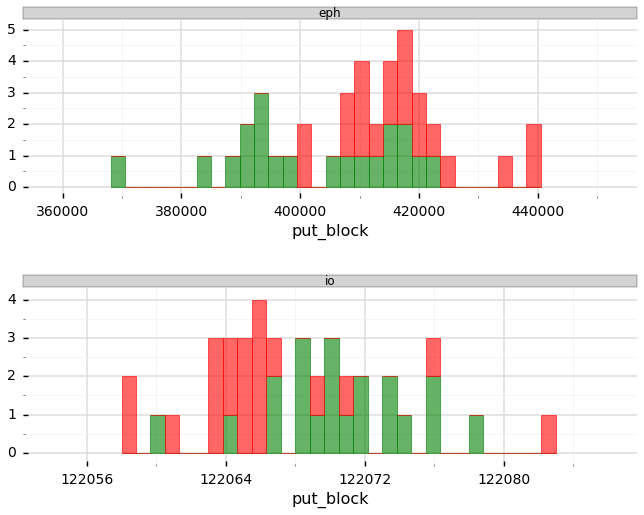

<ggplot: (-9223363242119393725)>

In [39]:
s = ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_histogram(alpha=.6) +\
    facet_wrap("dev_type") +scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/disk-io-2.png",s,dpi=96)
s

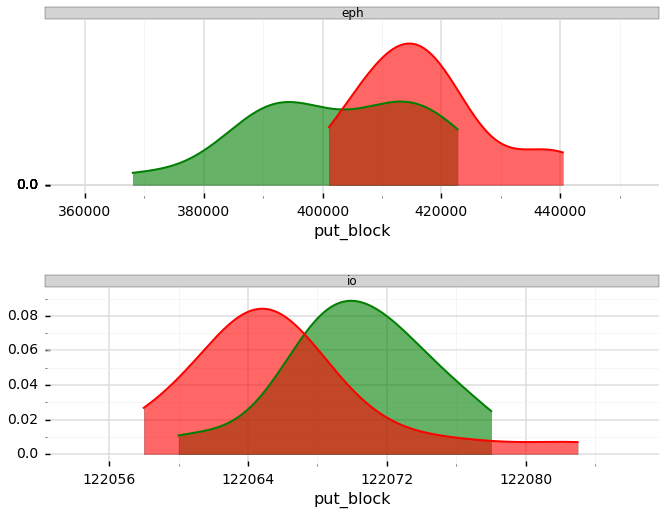

<ggplot: (-9223363242115905518)>

In [40]:
s = ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type")+scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/disk-io-3.png",s,dpi=96)
s

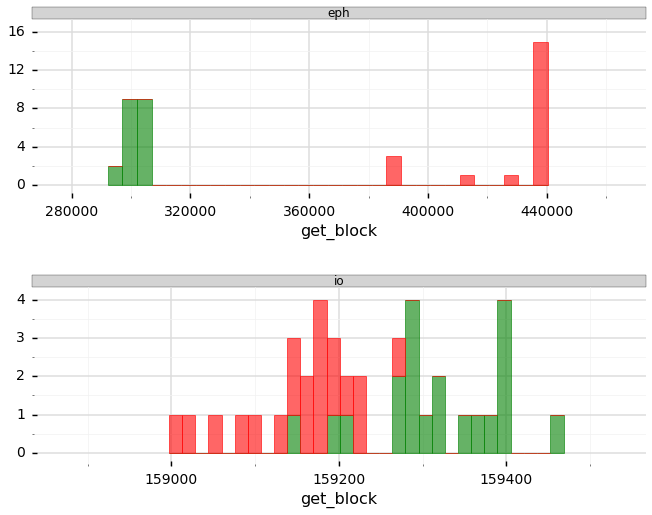

<ggplot: (8794734986560)>

In [41]:
s = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_histogram(alpha=.6) + facet_wrap("dev_type") +scale_color_manual(values=["green", "red"])+\
    theme_seaborn(context='talk',style="whitegrid")
#ggsave("/tmp/disk-io-4.png",s,dpi=96)
s

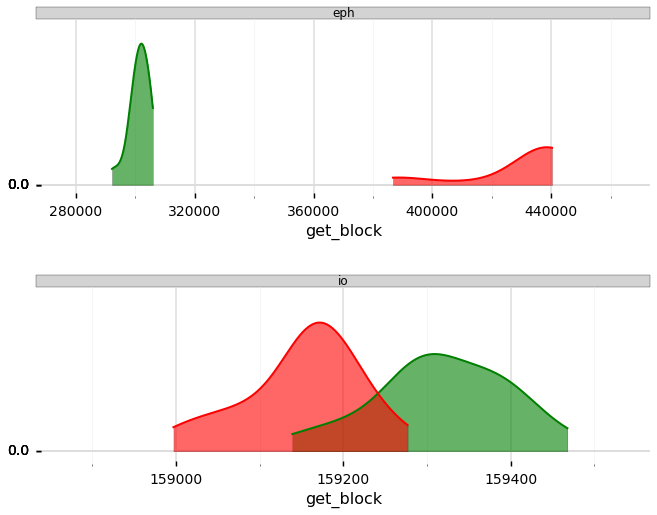

<ggplot: (-9223363242119693354)>

In [42]:
s = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie)+\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type") + scale_color_manual(values=["green", "red"])+\
    theme_seaborn(style="whitegrid",context='talk')
#ggsave("/tmp/disk-io-5.png",s,dpi=96)
s